<a href="https://colab.research.google.com/github/CeciliaYSui/PFP_Tutorial/blob/main/Online_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial is designed for first-time users of transformer-based language models for measuring latent concepts in social science research. It is designed to go alongside this paper: https://osf.io/preprints/socarxiv/w7q43_v1
More detailed explanation of the model architecture and pros and cons are provided in the paper.


# **Section 1: Using models directly for inference**

The easiest way to use these models is to apply available off-the-shelf classifiers directly to our data at hand. This process requires minimal computational resources, and may even be done without any GPU and on a CPU, especially when the size of the dataset is relatively small. However, please be aware that using CPU only might make the inference time longer. This section below walks through a simple application to classify some tweets using an off-the-shelf toxicity classifier already trained.

To illustrate the feasibility of using CPU only for classification, we can select the 'CPU' option on Colab with High-RAM. The script below is also executable using all other 'GPU' options, as well as on Apple Silicon chips. Scholars can manually set `device='cpu'`, `device='cuda'`, or `device='mps'` to use them respectively.


## **Step 1: Install dependencies**

Before we start, we first need to install the dependencies.
Depending on the specific model we choose to use, we might need to source-install the transformer library through:
`!pip install git+https://github.com/huggingface/transformers.git`
For most models, `!pip install transformers` should work just fine.

Now we need to load the libraries we need, and set up the working directory to access our data files.

In [2]:
!pip install transformers

# # When we need to source-install 'transformers'
# !pip install git+https://github.com/huggingface/transformers.git

# Load libraries
import pandas as pd
from transformers import pipeline

# set up working directory
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/3YP_Cecilia

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/3YP_Cecilia


## **Step 2: Load the model**

To apply an off-the-shelf classifier from HuggingFace Hub, we now need to load the model. For illustration purposes and to go along the paper, I will use toxicity classificaiton as an example for this demo.


In [3]:
# Find the model name from their huggingface page: https://huggingface.co/AnonymousCS/bert-large-uncased-Twitter-toxicity
model_name = "AnonymousCS/bert-large-uncased-Twitter-toxicity"

# If you do not have access to a GPU, and only want to run inference on your CPU, you can run this.
# Note that this will take longer for inference, but is still manageable with small datasets.
classifier = pipeline(model=model_name, device='cpu')


# To utilize the GPU, set device='cuda'
# classifier = pipeline(model=model_name, device='cuda')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cpu


Depending on the model chosen to use, you might need to authenticate to your HuggingFace account in order to load the model. You can obtain huggingface token from here: https://huggingface.co/docs/hub/en/security-tokens

Then run the code below and enter your access token.

In [27]:
from huggingface_hub import notebook_login
notebook_login()

## **Step 3: Apply to our data**

Now that we have loaded our desired classifier, we are ready to apply it to our data.


In [5]:
# First, we need to load the dataset we want to classify
test_df = pd.read_csv("./training_data/test.csv")

# Now we apply the classifier to our dataframe
predicted_labels = [classifier(x)[0] for x in test_df['text']]

# predicted_labels
pred_df = pd.DataFrame.from_dict(predicted_labels)
# strip the label to only show 0, or 1 and convert them into integers
pred_df['label'] = pred_df['label'].str[-1].astype(int)

# Append the classification results to our original dataset along with their probability scores
test_df['predicted_label'] = pred_df['label']
test_df['probs'] = pred_df['score']
test_df

# Now export to .csv file and save it
# test_df.to_csv("./test_eval/bert-base-uncased-Twitter-toxicity.csv")

,id,text,label,predicted_label,probs
0,1330565145354006528,@imwoman11 @SenSanders Keep looking at the gra...,0,0,0.894184
1,1312847628519051268,@ArtsyOma @shout4ztruth @SenFeinstein @realDon...,1,1,0.970969
2,1326379385138647041,@CoryBooker @JoeBiden Election is not over. Re...,0,0,0.954254
3,1320710308055392258,@otto_maddoxx @SenTedCruz For @tedcruz to “sta...,1,0,0.747938
4,1330756838921555968,@SenRickScott @UN @ErikRosalesNews Who are in ...,0,0,0.981763
...,...,...,...,...,...
274,1322700877694750721,"@senrobportman Boo MFer! Bet you jumped, you c...",1,1,0.994573
275,1321481162649407494,@SenToddYoung Why Women Hate Trump https://t.c...,0,0,0.888401
276,1318017212876279820,@ChuckGrassley You really do have terrible gra...,1,1,0.994354
277,1314305474427260928,@SenJohnThune @DeneseLivengood Plus she &amp; ...,0,0,0.938840


## **Step 4: Evaluate the performance**

Awesome! You have now successfully classified some data using a transformer-based language model. Now let's look at how it did comparing to the true labels.

For this demo, we will look at some classic metrics and a confusion matrix. There are other performance metrics available to use as well, and may be more suitable for more imbalanced data.  

              precision    recall  f1-score   support

           0     0.8994    0.9212    0.9102       165
           1     0.8818    0.8509    0.8661       114

    accuracy                         0.8925       279
   macro avg     0.8906    0.8860    0.8881       279
weighted avg     0.8922    0.8925    0.8922       279

balanced accuracy: 0.886


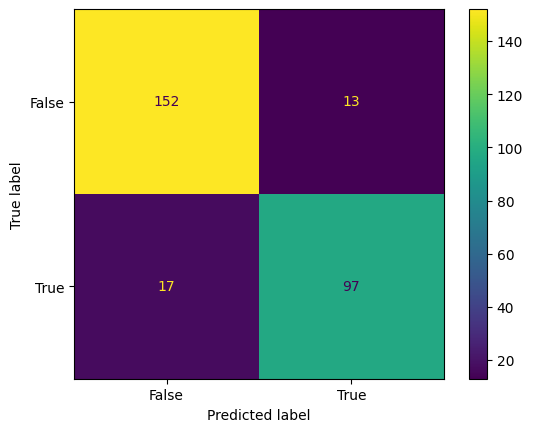

In [8]:
### Evaluation of predicted outputs
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

print(classification_report(test_df['label'],test_df['predicted_label'], digits=4))
print("balanced accuracy:", round(balanced_accuracy_score(test_df['label'],test_df['predicted_label']),4))

confusion_matrix = metrics.confusion_matrix(test_df['label'],test_df['predicted_label'], )
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

The results look pretty good. Let's look at some example tweets to evaluate their face validity.

Let's check the first two rows. It looks like one is toxic, while the other one is not.


In [23]:
test_df.head(2)

,id,text,label,predicted_label,probs
0,1330565145354006528,@imwoman11 @SenSanders Keep looking at the gra...,0,0,0.894184
1,1312847628519051268,@ArtsyOma @shout4ztruth @SenFeinstein @realDon...,1,1,0.970969


In [25]:
# Let's look at the exact text in this first tweet
test_df['text'][0]

'@imwoman11 @SenSanders Keep looking at the graph, the entire United States will be "regulated" like the blue lines soon if you seriously believe that.'

The first tweets seems a little sarcastic maybe upset, but definitely not toxic based on our definition offered in this paper.

What about the second one?

In [26]:
test_df['text'][1]

'@ArtsyOma @shout4ztruth @SenFeinstein @realDonaldTrump God is sick and tired of the liberals killing babies!'

This tweet definitely meets our criteria for a toxic tweet. The classifier classified it as a 1 with a pretty high probability score.






<br/><br/>

***

<br/><br/>

# **Section 2: Fine-tuning models with our own annotated data**

Now we know how to apply off-the-shelf classifiers directly to our data! We can also fine-tune some base models with our custom annotated data. To do this, we would need some GPU power! But don't worry, previous works have shown that fine-tuning does not need a lot of data. Oftentimes, a few hundreds of annotated examples should be enough for the model to learn from. If you have a consumer-grade computer with some sort of GPU, you should be just fine! Of course, more compute power may reduce your fine-tuning time. There is always the trade-off.

To get ourselves ready for the fine-tuning exercise, let's change our runtime type to the T4 GPU if you're using Google Colab. This is freely available to all Colab users. For paid users, there is also the L4 GPU and the A100 GPU, which are both several times faster than the T4 GPU.  

In [ ]:
# When we change the runtime type on Colab, we may need to install new dependencies and load the libraries
!pip install datasets evaluate accelerate # transformers

# Load libraries
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

# set up working directory
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/3YP_Cecilia

from huggingface_hub import notebook_login
notebook_login()

## **Step 1: Load the model**

We need to first load the desired base model to start our fine-tuning process.

In this demo, we will use the classic `bert-base-uncased` as an example. It can be changed to pretty much any model hosted on HuggingFace Hub. Please be aware that larger models will require more compute power to train or fine-tune. For example, it might not be feasible to fine-tune or even do inference with models like `bigscience/bloom` on a consumer-grade laptop or the free tier Google Colab. However, besides these large models, there are plenty of models available on HuggingFace Hub that are "small" enough for us to use with a consumer-grade computer. Many of these have been shown to work great on various different applications.

In [ ]:
model_name = "google-bert/bert-base-uncased"

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels = 2 # increase for multi-class tasks
)

# We also need to load the tokenizer with the model since we need to tokenize our data prior to feeding them into the model
# Please refer to the associated paper on why and how tokenization works in the PFP pipeline.
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## **Step 2: Prepare our data**

In order to fine-tune a pre-trained language model, we need to have a training set and a validation set. The code below helps to prepare our annotated data file to be ready to use by the model.

We can either supply two separate data files for training and validation separatley, or give one file to `prep_data()` to split it for us by setting `need_split=True`.

For scholars who are more familiar with object-oriented programming, we can also create a custom class for our dataset to handle the tokenizaation, sequence length, among other things and provide a neat package. For now, we will just use this simple function.

In [2]:
# # prepare dataset
# df_train: dataframe of training data (or just an entire dataset that has not been split to train/validate)
# df_val: dataframe of validation data if already split into train/validate
# need_split: a boolean variable indicating whether the data needs to be split into train/validate
# random_seed: for reproducibility

def prep_data(df_train, df_val=None, need_split=True, random_seed = 42):
  if need_split:
    df_train, df_val = train_test_split(df_train, random_state = random_seed) # returns 2 dataframes

  training = pd.DataFrame({
      "label": list(df_train['label']),
      "text": list(df_train['text']),
      "id": list(df_train['id'])
  })
  train_dataset = Dataset.from_dict(training)
  validation = pd.DataFrame({
      "label": list(df_val['label']),
      "text": list(df_val['text']),
      "id": list(df_val['id'])
  })
  val_dataset = Dataset.from_dict(validation)
  my_dataset_dict = DatasetDict({"train":train_dataset,"val":val_dataset})

  return my_dataset_dict


def preprocess_function(my_data):
  return tokenizer(my_data["text"], truncation=True)


df1 = pd.read_csv('./training_data/train.csv')
df2 = pd.read_csv('./training_data/validate.csv')
data = prep_data(df1, df2, need_split = False)
tokenized_data = data.map(preprocess_function, batched=True)

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'id'],
        num_rows: 2232
    })
    val: Dataset({
        features: ['label', 'text', 'id'],
        num_rows: 279
    })
})

Let's look at an example of a tokenized tweet:

In [ ]:
tokenizer(data['train'][0]['text'], truncation=True)

## **Step 3: Fine-tune our model**


The `Trainer` class provides an API for feature-complete training in PyTorch, and it supports distributed training on multiple GPUs/TPUs, mixed precision for NVIDIA GPUs, AMD GPUs, and torch.amp for PyTorch. Trainer goes hand-in-hand with the TrainingArguments class, which offers a wide range of options to customize how a model is trained. Together, these two classes provide a complete training API.

More information on the `Trainer` class: https://huggingface.co/docs/transformers/en/main_classes/trainer

Here're available arguments that we can customize for the TrainingArugments class: https://huggingface.co/docs/transformers/v4.49.0/en/main_classes/trainer#transformers.TrainingArguments


While it is a good practice to tune the hyperparameters such as learning rate, batch size, number of epochs, etc., doing so requires a lot more compute resources and sometimes do not provide enough performance gain to justify the cost when resource is limited. The great thing about using these models is that they can work with most common set of hyperparameters even without tuning.



In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


training_args = TrainingArguments(
    output_dir="my_test_model", # name it whatever we want!
    learning_rate=2e-5, # typical learning rate: 1e-5, 2e-5, 1e-4, 1e-3 ...
    per_device_train_batch_size=32, # batch size are usually powers of 2, though not necessary
    per_device_eval_batch_size=32, # less compute power may require a smaller batch size, similar for smaller datasets
    num_train_epochs=4, # typically 2-5 epochs
    weight_decay=0.01,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    # fp16=True, # mixed precision (help to speed up the process, and full precision is often not needed)
    push_to_hub=True, # You can always push your trained model to HuggingFace Hub to share it for others to use. Make sure to authenticate before doing this.
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Now we're ready to fine-tune the model and push it to hub! After it's been pushed to HuggingFace Hub, anyone with the model name can use it now, unless we set it to private. We can also require access requests to control who can use our models.

In [ ]:
trainer.train()
trainer.push_to_hub()

## **Step 4: More customization**

Thanks to the flexibility of programming, we can pretty much customize any component mentioned above. We can define our own classifier class to set the desired number of layers. We can define our own loss function. Once we're more experienced with using these established classes, we can always look into their source code and add our customization wherever we desire. In this step, we will walk through a simple example of a custom loss function.

For imbalanced data, we might want to change the loss function so that it puts higher weight for the less common class. To do so, we can define a `CustomTrainer` class that inherits everything from the original `Trainer` class that we just used above.

In this example, we just manually set a fixed weights for negative and positive cases in a binary classification. Specific formula and method to calculate weights depend on the problem and dataset. There are also other loss functions to use for different types of applciations.

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.4, 0.6], device = 'cuda')) # # higher weight for positive class
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

Once we've defined the `CustomTrainer` class, we can simply replace the previous `Trainer` class to `CustomTrainer`, and re-do the fine-tuning process. Remember that `CustomTrainer` inherits everything from the `Trainer` class.

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Now we can re-do the training and push the new model to hub!

Be careful that without changing the model `output_dir` argument in `TrainingArguments`, pushing it to hub will overwrite the existing model. The good thing is that HuggingFace Hub keeps track of all the versions of the model, and you can always reverse or go back to older versions.

In [ ]:
trainer.train()
trainer.push_to_hub()

<br/><br/>

***

<br/><br/>

# **Section 3: Re-fining with masked-language-models with unlabeled data**

Sometimes, the available pre-trained models are trained in data quite different from what we want to use it for. For example, we might want to apply the model to analyze tweets or legal documents, which may need a little bit more understanding of the specific language used by tweets or legal documents. So we might want to re-fine the pre-trained models with our own dataset to help it learn the syntax and semantics of the specific domain.

There are many different ways to re-fine these pre-trained models. In this demo, we will just use the masked-language-modeling (MLM) approach to re-fine an encoder-only model. Intuitively, MLM masks some random tokens (or words) within a sequence and ask the model to predict what these missing tokens are. By repeatedly doing so, the model gradually learns to understand the language better.

More information: https://github.com/huggingface/transformers/tree/main/examples/pytorch/language-modeling

In [ ]:
!pip install -r requirements.txt


# Again we might need to source-install transformers for certain models such as MODERN-BERT. If so, run this instead
# !pip install git+https://github.com/huggingface/transformers

# !pip install flash-attn triton # Some models may require other dependencies such as flash-attn

In [ ]:
!python run_mlm.py \
    --model_name_or_path google-bert/bert-base-multilingual-cased \
    --train_file training_text.txt \
    --validation_file test_text.txt \
    --per_device_train_batch_size 32 \
    --per_device_eval_batch_size 32 \
    --do_train \
    --do_eval \
    --output_dir ./refined_model_name \
    --pad_to_max_length \
    --line_by_line
    # --overwrite_output_dir